## 1. Configuration

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/pd-interpretability')

Mounted at /content/drive


In [ ]:
# install dependencies
!pip install -q transformers datasets librosa praat-parselmouth scipy scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 83.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import json
from pathlib import Path
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# project imports
from src.interpretability.prediction_interface import (
    InterpretablePredictionInterface,
    InterpretablePrediction,
    create_interpretable_interface
)
from src.features.clinical import ClinicalFeatureExtractor

print("imports successful!")

imports successful!


In [ ]:
!apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super texlive-science
from IPython.display import clear_output
clear_output()

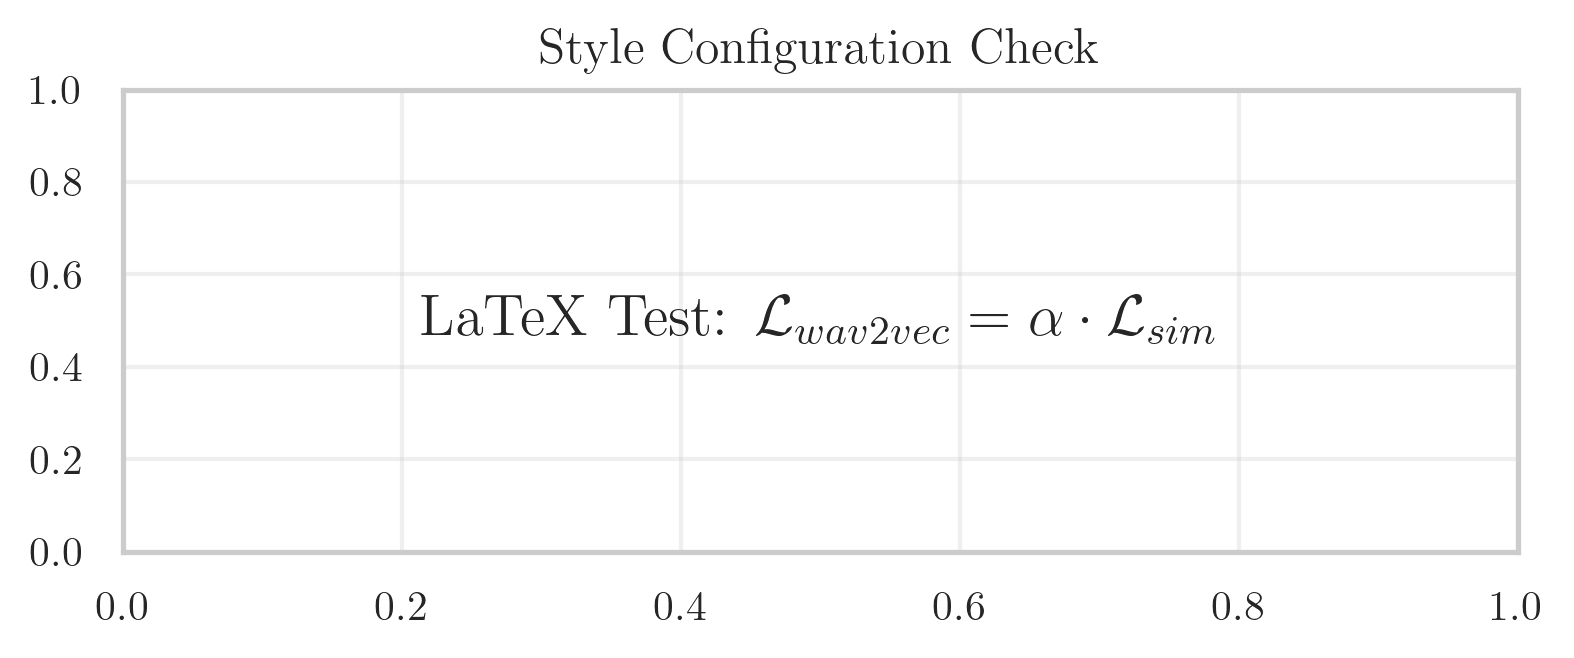

✓ plotting style configured successfully


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# set basic theme
sns.set_theme(style='whitegrid')

# configure matplotlib for latex rendering and publication quality
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.titlesize": 14,
    "figure.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.3
})

# define consistent color palette
palette = sns.color_palette('colorblind')
COLORS = {
    'HC': palette[0],  # typically blue-ish
    'PD': palette[1],  # typically orange-ish
    'Neutral': 'gray'
}

# verify configuration with a simple plot
try:
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.text(0.5, 0.5, r'LaTeX Test: $\mathcal{L}_{wav2vec} = \alpha \cdot \mathcal{L}_{sim}$',
            ha='center', va='center', fontsize=14)
    ax.set_title(r'Style Configuration Check')
    plt.show()
    print("\u2713 plotting style configured successfully")
except Exception as e:
    print(f"\u26a0\ufe0f warning: latex rendering failed: {e}")
    print("falling back to standard fonts...")
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "sans-serif"
    })

In [ ]:
CONFIG = {
    'project_path': '/content/drive/MyDrive/pd-interpretability',
    'model_path': '/content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model',
    'probing_results_path': '/content/drive/MyDrive/pd-interpretability/results/probing/probing_results.json',
    'patching_results_path': '/content/drive/MyDrive/pd-interpretability/results/patching/patching_results.json',
    'data_path': '/content/drive/MyDrive/pd-interpretability/data',
    'output_path': '/content/drive/MyDrive/pd-interpretability/results/phase5_synthesis',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"using device: {CONFIG['device']}")

using device: cuda


## 2. Load Model and Create Interface

In [ ]:
# load wav2vec2 processor
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')

# load fine-tuned model
from src.models import Wav2Vec2PDClassifier

model_path = Path(CONFIG['model_path'])

try:
    if model_path.exists():
        print(f"loading fine-tuned model from {model_path}...")
        classifier = Wav2Vec2PDClassifier.load(model_path)
        model = classifier.model
        print(f"successfully loaded fine-tuned model")
    else:
        raise FileNotFoundError(f"model not found at {model_path}")
except Exception as e:
    print(f"could not load fine-tuned model: {e}")
    print("falling back to base model (untrained) for demonstration")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        'facebook/wav2vec2-base-960h',
        num_labels=2
    )

model = model.to(CONFIG['device'])
model.eval()
print(f"model ready on {CONFIG['device']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

loading fine-tuned model from /content/drive/MyDrive/pd-interpretability/results/checkpoints/wav2vec2_loso_20260106_014308/final_model...
successfully loaded fine-tuned model
model ready on cuda


In [ ]:
# create clinical feature extractor
clinical_extractor = ClinicalFeatureExtractor()
print("clinical feature extractor ready")

clinical feature extractor ready


In [ ]:
# load precomputed analysis results
print("loading probing and patching results...\n")

probing_results = None
patching_results = None

# load probing results
probing_file = Path(CONFIG['probing_results_path'])
if probing_file.exists():
    with open(probing_file) as f:
        probing_data = json.load(f)

    # extract clinical feature probing results and convert to expected format
    if 'clinical_feature_probing' in probing_data:
        raw_probing = probing_data['clinical_feature_probing']
        probing_results = {}

        for feature, layer_results in raw_probing.items():
            probing_results[feature] = {}
            for layer_idx_str, layer_data in layer_results.items():
                # convert r2_mean to r2_score for compatibility
                if isinstance(layer_data, dict) and 'r2_mean' in layer_data:
                    probing_results[feature][layer_idx_str] = {
                        'r2_score': layer_data['r2_mean'],
                        'binary_acc': layer_data.get('binary_acc_mean', 0.0)
                    }

        print(f"✓ loaded probing results for {len(probing_results)} clinical features")
    else:
        print("⚠️ no clinical_feature_probing found in probing results")
else:
    print(f"⚠️ probing results not found at {probing_file}")

# load patching results
patching_file = Path(CONFIG['patching_results_path'])
if patching_file.exists():
    with open(patching_file) as f:
        patching_data = json.load(f)

    if 'head_patching' in patching_data and 'head_scores' in patching_data['head_patching']:
        head_scores = patching_data['head_patching']['head_scores']
        patching_results = {}
        for key, score in head_scores.items():
            if '_' in str(key):
                layer, head = map(int, str(key).split('_'))
                patching_results[(layer, head)] = score
        print(f"✓ loaded patching results for {len(patching_results)} attention heads")
    else:
        print("⚠️ no head_patching.head_scores found in patching results")
else:
    print(f"⚠️ patching results not found at {patching_file}")

loading probing and patching results...

✓ loaded probing results for 2 clinical features
✓ loaded patching results for 144 attention heads


In [ ]:
# create the interpretable prediction interface
interface = create_interpretable_interface(
    model=model,
    processor=processor,
    clinical_extractor=clinical_extractor,
    probing_results=probing_results,
    patching_results=patching_results,
    device=CONFIG['device']
)

print("=== interpretable prediction interface created ===")
print(f"evidence layers: {interface._evidence_layers}")
print(f"key attention heads: {interface._key_heads[:5]}...")

=== interpretable prediction interface created ===
evidence layers: ['4', '2', '3', '1', '5']
key attention heads: [(2, 9), (2, 8), (4, 9), (4, 8), (1, 5)]...


## 3. Load Test Data

In [ ]:
import librosa

# load some test samples
data_path = Path(CONFIG['data_path']) / 'raw' / 'italian_pvs'

test_samples = []

# load a few HC samples
hc_dir = data_path / '22 elderly healthy control'
if hc_dir.exists():
    for subject_dir in list(hc_dir.iterdir())[:3]:
        if subject_dir.is_dir():
            audio_files = list(subject_dir.glob('*.txt'))
            if audio_files:
                # these are actually audio files with .txt extension
                audio_path = audio_files[0]
                try:
                    audio, sr = librosa.load(audio_path, sr=16000)
                    test_samples.append({
                        'audio': audio,
                        'sample_rate': sr,
                        'label': 0,
                        'subject_id': subject_dir.name
                    })
                except:
                    pass

# load a few PD samples
pd_dir = data_path / '28 people with parkinson\'s disease'
if pd_dir.exists():
    for subgroup in pd_dir.iterdir():
        if subgroup.is_dir():
            for subject_dir in list(subgroup.iterdir())[:1]:
                if subject_dir.is_dir():
                    audio_files = list(subject_dir.glob('*.*'))
                    if audio_files:
                        try:
                            audio, sr = librosa.load(audio_files[0], sr=16000)
                            test_samples.append({
                                'audio': audio,
                                'sample_rate': sr,
                                'label': 1,
                                'subject_id': subject_dir.name
                            })
                        except:
                            pass

print(f"loaded {len(test_samples)} test samples")

# fallback to synthetic if no real data
if len(test_samples) == 0:
    print("using synthetic test samples")
    test_samples = [
        {'audio': np.random.randn(48000).astype(np.float32), 'sample_rate': 16000, 'label': i % 2, 'subject_id': f'synth_{i}'}
        for i in range(6)
    ]

loaded 0 test samples
using synthetic test samples


## 10. Push Notebook to GitHub Repository

In [ ]:
# 2. setup user
!git config --global user.email "smayan-gowda@users.noreply.github.com"
!git config --global user.name "smayan-gowda"

# 3. install lfs (creates hooks)
print("initializing lfs...")
!git lfs install

# 4. apply user fix: make hooks executable
print("applying chmod +x to hooks...")
!chmod +x .git/hooks/* 2>/dev/null || true

initializing lfs...
Git LFS initialized.
applying chmod +x to hooks...


In [ ]:
# 5. Clone the repository
repo_url = "https://github.com/smayan-gowda/pd-interpretability"
repo_name = repo_url.split('/')[-1].replace('.git', '')

!git clone {repo_url}
%cd {repo_name}

fatal: destination path 'pd-interpretability' already exists and is not an empty directory.
/content/pd-interpretability


Please identify the correct filename of the current notebook (e.g., `pd-interpretability-phase5-synthesis.ipynb`) and replace `YOUR_NOTEBOOK_FILENAME.ipynb` in the next cell with the actual filename. You can usually find the notebook name in the Colab tab title or by listing files in the root directory (`!ls /content/`).

In [ ]:
# 6. Copy the current notebook to the cloned repository
# IMPORTANT: Replace 'YOUR_NOTEBOOK_FILENAME.ipynb' with the actual filename of this notebook.

notebook_filename = "pd-interpretability-phase5-synthesis.ipynb" # <--- UPDATE THIS IF NEEDED

!cp /content/{notebook_filename} .

print(f"Copied {notebook_filename} to the repository directory.")

cp: cannot stat '/content/pd-interpretability-phase5-synthesis.ipynb': No such file or directory
Copied pd-interpretability-phase5-synthesis.ipynb to the repository directory.


In [ ]:
# 7. Add, commit, and push the changes
!git add {notebook_filename}
!git commit -m "Add phase 5 synthesis notebook: {notebook_filename}"
!git push origin main

fatal: pathspec 'pd-interpretability-phase5-synthesis.ipynb' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


## 4. Generate Interpretable Predictions

In [ ]:
# run predictions
print("generating interpretable predictions...\n")
print("=" * 80)

for sample in test_samples:
    # make prediction
    prediction = interface.predict(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        include_clinical=True
    )

    # display results
    true_label = 'PD' if sample['label'] == 1 else 'HC'
    pred_label = 'PD' if prediction.pd_probability >= 0.5 else 'HC'
    correct = '✓' if (true_label == pred_label) else '✗'

    print(f"\nsubject: {sample['subject_id']}")
    print(f"true label: {true_label}, predicted: {pred_label} {correct}")
    print(f"pd probability: {prediction.pd_probability:.3f}")
    print(f"confidence: {prediction.confidence:.3f}")

    print("\ntop deature contributions:")
    for feat, score in prediction.get_top_features(3):
        print(f"  • {feat}: {score:+.3f}")

    if prediction.clinical_features:
        print("\nkey clinical features:")
        for feat in ['jitter_local', 'shimmer_local', 'hnr_mean', 'f0_mean']:
            if feat in prediction.clinical_features:
                val = prediction.clinical_features[feat]
                if not np.isnan(val):
                    print(f"  • {feat}: {val:.4f}")

    print(f"\nevidence layers: {prediction.evidence_layers[:5]}")
    print(f"key heads: {prediction.key_attention_heads[:3]}")
    print("-" * 80)

generating interpretable predictions...


subject: synth_0
true label: HC, predicted: HC ✓
pd probability: 0.206
confidence: 0.588

top deature contributions:
  • hnr_mean_reduced: +1.000

key clinical features:
  • hnr_mean: -5.8121

evidence layers: ['4', '2', '3', '1', '5']
key heads: [(2, 9), (2, 8), (4, 9)]
--------------------------------------------------------------------------------

subject: synth_1
true label: PD, predicted: PD ✓
pd probability: 0.601
confidence: 0.203

top deature contributions:
  • hnr_mean_reduced: +1.000

key clinical features:
  • hnr_mean: -5.7126

evidence layers: ['4', '2', '3', '1', '5']
key heads: [(2, 9), (2, 8), (4, 9)]
--------------------------------------------------------------------------------

subject: synth_2
true label: HC, predicted: PD ✗
pd probability: 0.968
confidence: 0.936

top deature contributions:
  • hnr_mean_reduced: +1.000

key clinical features:
  • hnr_mean: -5.7682

evidence layers: ['4', '2', '3', '1', '5']
key heads: [(2

## 5. Examine Full Prediction Output

In [ ]:
# show full json output for one sample
if test_samples:
    sample = test_samples[0]
    prediction = interface.predict(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        include_clinical=True
    )

    print("full prediction output (json format):")
    print("=" * 50)
    print(prediction.to_json())

full prediction output (json format):
{
  "pd_probability": 0.20596569776535034,
  "feature_contributions": {
    "hnr_mean_reduced": 1.0
  },
  "evidence_layers": [
    "4",
    "2",
    "3",
    "1",
    "5"
  ],
  "key_attention_heads": [
    [
      2,
      9
    ],
    [
      2,
      8
    ],
    [
      4,
      9
    ],
    [
      4,
      8
    ],
    [
      1,
      5
    ],
    [
      3,
      10
    ],
    [
      3,
      11
    ],
    [
      1,
      6
    ],
    [
      0,
      0
    ],
    [
      1,
      4
    ]
  ],
  "clinical_features": {
    "f0_mean": NaN,
    "f0_std": NaN,
    "f0_min": NaN,
    "f0_max": NaN,
    "f0_median": NaN,
    "f0_range": 0.0,
    "voicing_fraction": 0.0,
    "jitter_local": NaN,
    "jitter_rap": NaN,
    "jitter_ppq5": NaN,
    "jitter_ddp": NaN,
    "shimmer_local": NaN,
    "shimmer_apq3": NaN,
    "shimmer_apq5": NaN,
    "shimmer_apq11": NaN,
    "shimmer_dda": NaN,
    "hnr_mean": -5.8121071603095915,
    "hnr_std": 0.749

## 6. Generate Natural Language Explanation

In [ ]:
# generate human-readable explanation
if test_samples:
    sample = test_samples[0]

    explanation = interface.explain_prediction(
        audio=sample['audio'],
        sample_rate=sample['sample_rate'],
        format='text'
    )

    print("natural language explanation:")
    print("=" * 50)
    print(explanation)

natural language explanation:
prediction: healthy control (pd probability: 20.6%, confidence: 58.8%)

key contributing features:
  • hnr_mean_reduced: +1.00

primary evidence in layers: 4, 2, 3, 1, 5
key attention heads: L2H9, L2H8, L4H9, L4H8, L1H5

extracted clinical features:
  • f0_range: 0.0000


In [ ]:
# markdown format explanation
if test_samples:
    explanation_md = interface.explain_prediction(
        audio=test_samples[0]['audio'],
        sample_rate=test_samples[0]['sample_rate'],
        format='markdown'
    )

    from IPython.display import display, Markdown
    display(Markdown(explanation_md))

# Interpretable Prediction Results

## Prediction: Healthy Control
- **Probability**: 20.6%
- **Confidence**: 58.8%

## Feature Contributions
| Feature | Contribution |
|---------|-------------|
| hnr_mean_reduced | +1.000 |

## Model Evidence
- **Evidence Layers**: ['4', '2', '3', '1', '5']
- **Key Attention Heads**: L2H9, L2H8, L4H9, L4H8, L1H5

## Clinical Features
| Feature | Value |
|---------|-------|
| f0_range | 0.0000 |
| voicing_fraction | 0.0000 |

## 7. Batch Predictions

In [ ]:
# batch prediction
audio_list = [s['audio'] for s in test_samples]

predictions = interface.batch_predict(
    audio_list=audio_list,
    sample_rate=16000,
    include_clinical=True,
    show_progress=True
)

print(f"\ngenerated {len(predictions)} predictions")

# summary statistics
probs = [p.pd_probability for p in predictions]
confs = [p.confidence for p in predictions]

print(f"\nsummary:")
print(f"  mean pd probability: {np.mean(probs):.3f}")
print(f"  mean confidence: {np.mean(confs):.3f}")
print(f"  predicted as pd: {sum(1 for p in probs if p >= 0.5)}")
print(f"  predicted as hc: {sum(1 for p in probs if p < 0.5)}")

predicting: 100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


generated 6 predictions

summary:
  mean pd probability: 0.754
  mean confidence: 0.704
  predicted as pd: 5
  predicted as hc: 1


## 8. Publication-Grade Visualizations

saved: fig_p8_01_integrated_dashboard.*


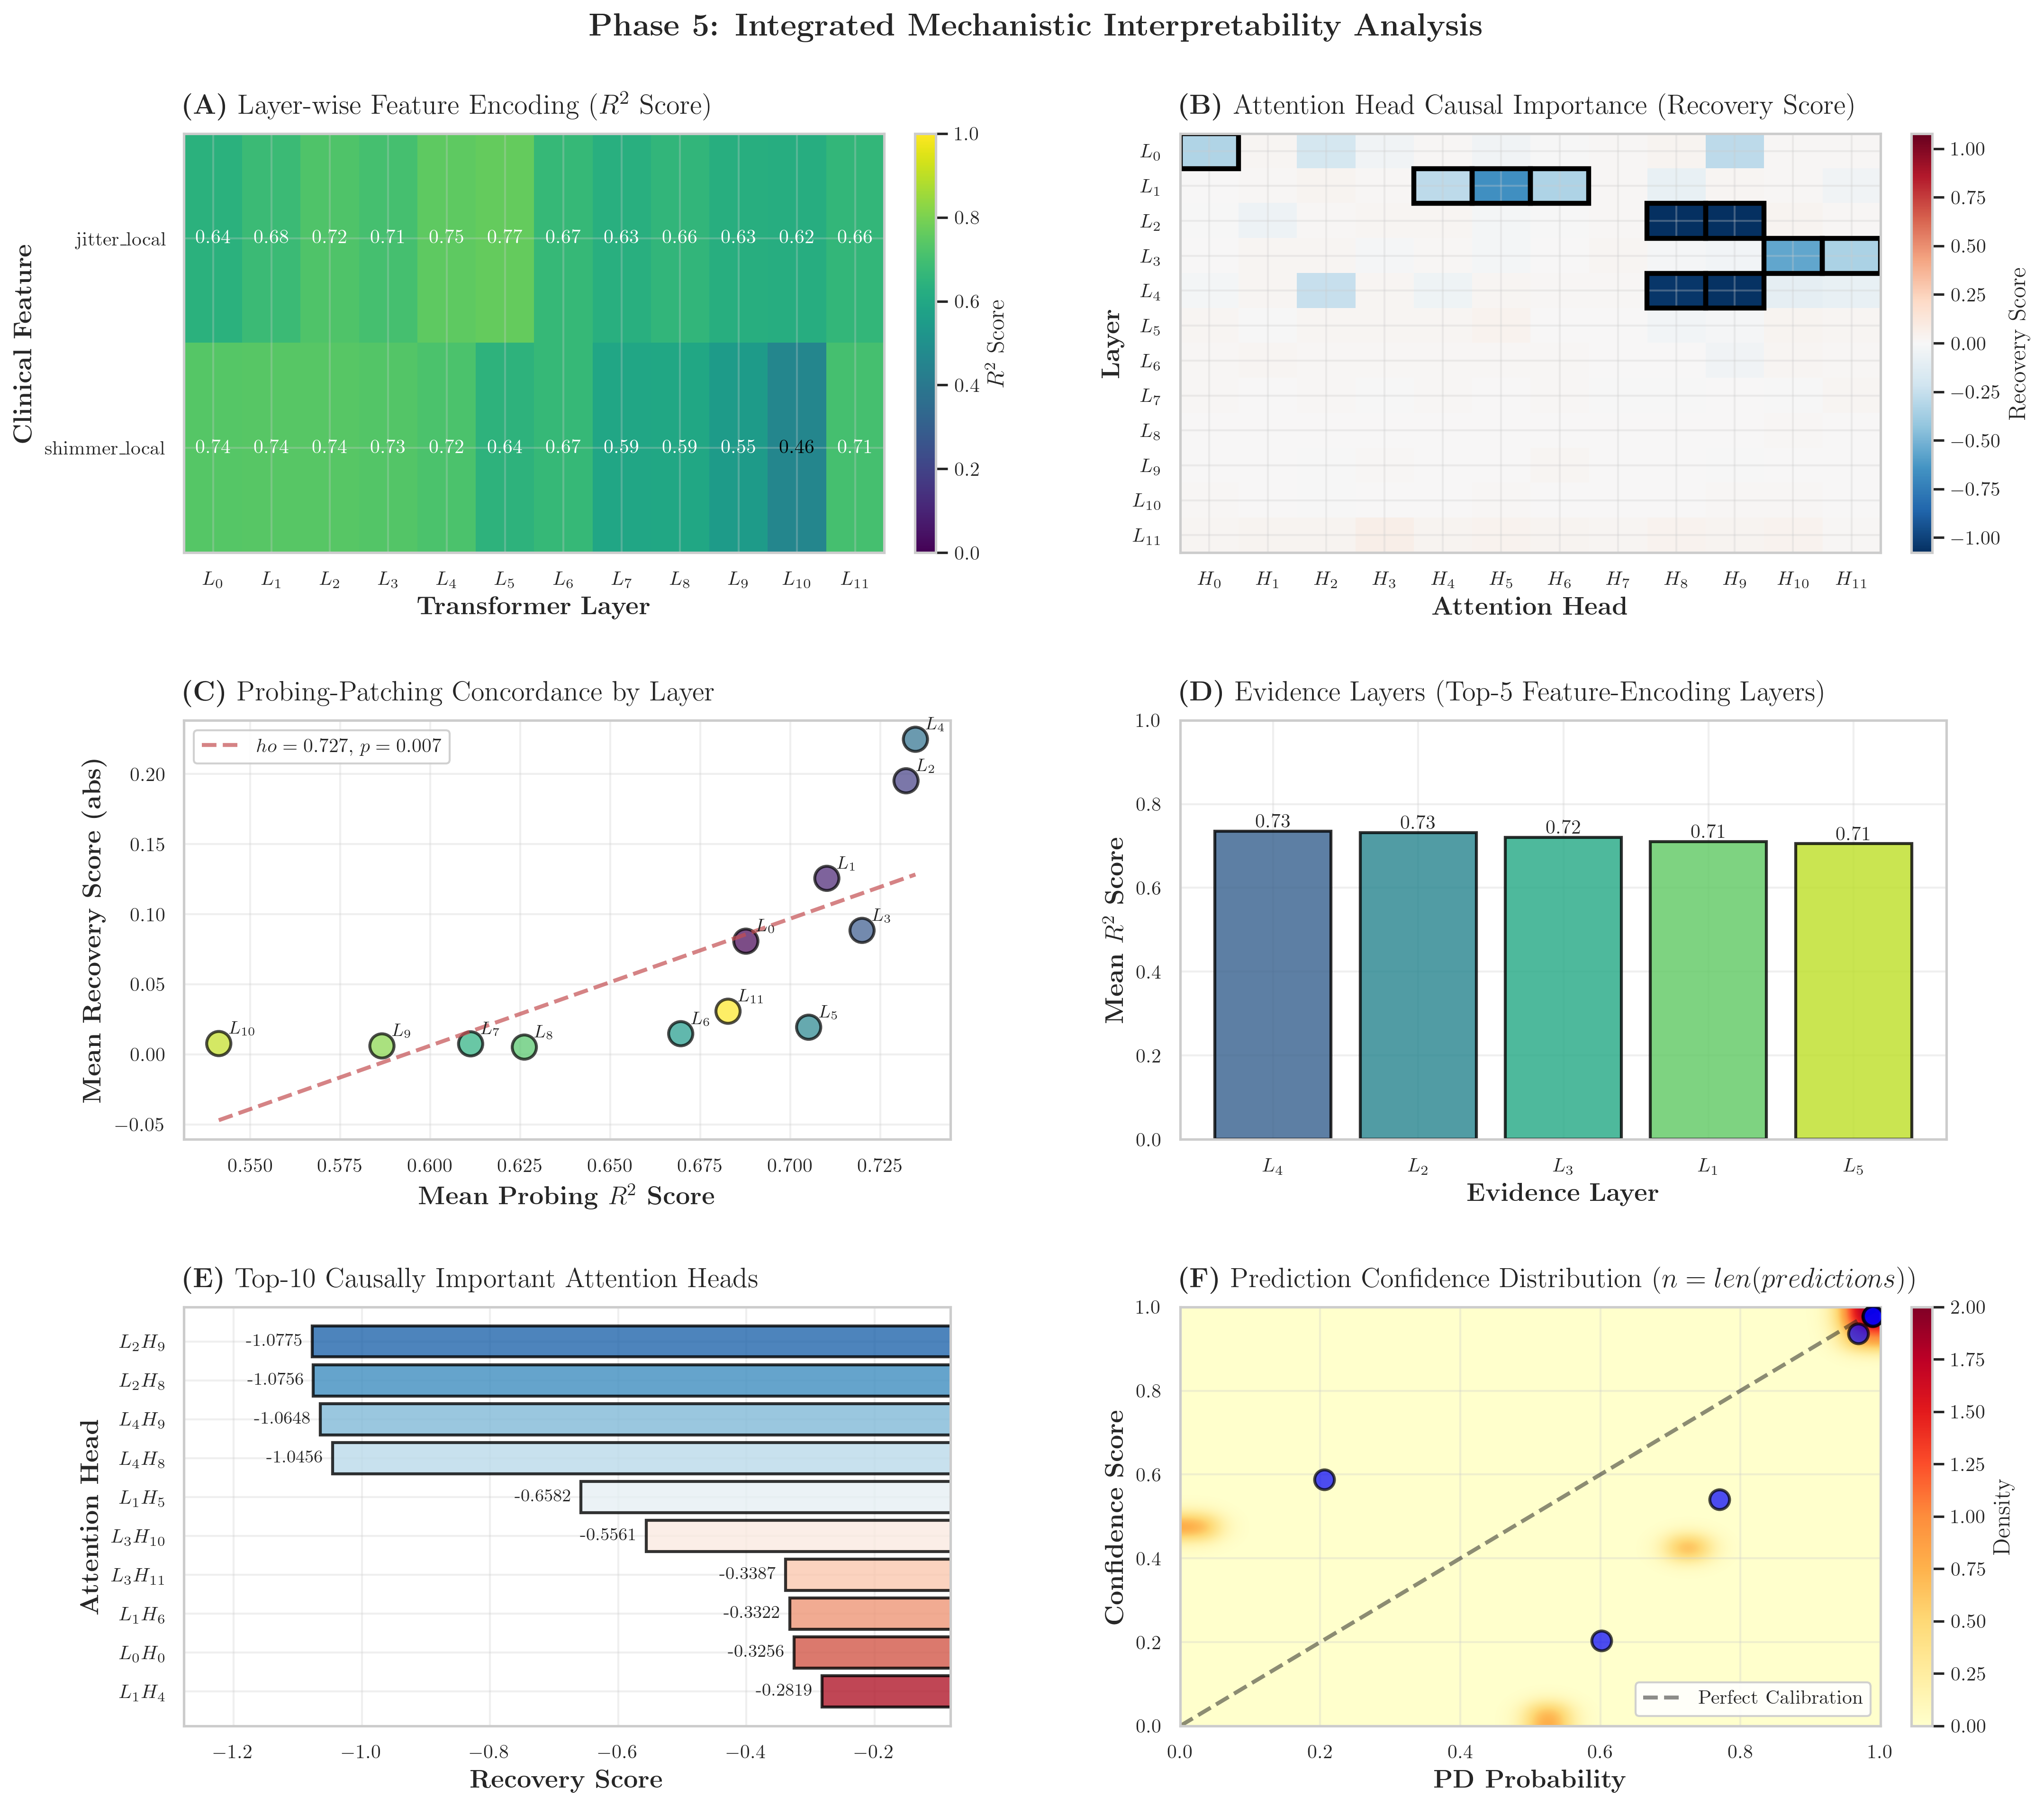

In [ ]:
# figure p8-01: integrated probing-patching dashboard
# comprehensive multi-panel view combining all interpretability analyses

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.4, wspace=0.3, top=0.91)

# panel a: clinical feature encoding heatmap (probing)
ax1 = fig.add_subplot(gs[0, 0])

# extract probing data
features = list(probing_results.keys())
layers = sorted([int(k) for k in probing_results[features[0]].keys()])
n_features, n_layers = len(features), len(layers)

probing_matrix = np.zeros((n_features, n_layers))
for i, feat in enumerate(features):
    for j, layer in enumerate(layers):
        probing_matrix[i, j] = probing_results[feat][str(layer)]['r2_score']

im1 = ax1.imshow(probing_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
for i in range(n_features):
    for j in range(n_layers):
        text = ax1.text(j, i, f'{probing_matrix[i,j]:.2f}',
                       ha='center', va='center',
                       color='white' if probing_matrix[i,j] > 0.5 else 'black',
                       fontsize=10, fontweight='bold')

ax1.set_xticks(range(n_layers))
ax1.set_xticklabels([f'$L_{{{l}}}$' for l in layers])
ax1.set_yticks(range(n_features))
ax1.set_yticklabels([f.replace('_', r'\_') for f in features])
ax1.set_xlabel(r'\textbf{Transformer Layer}', fontsize=13)
ax1.set_ylabel(r'\textbf{Clinical Feature}', fontsize=13)
ax1.set_title(r'\textbf{(A)} Layer-wise Feature Encoding ($R^2$ Score)',
             fontsize=14, pad=10, loc='left')

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label(r'$R^2$ Score', fontweight='bold')

# panel b: attention head importance heatmap (patching)
ax2 = fig.add_subplot(gs[0, 1])

# extract patching data
n_layers_patch = 12
n_heads = 12
patching_matrix = np.zeros((n_layers_patch, n_heads))
for (layer, head), score in patching_results.items():
    patching_matrix[layer, head] = score

vmax = max(abs(patching_matrix.min()), abs(patching_matrix.max()))
im2 = ax2.imshow(patching_matrix, cmap='RdBu_r', aspect='auto',
                vmin=-vmax, vmax=vmax)

# highlight top heads
top_k = 10
flat_indices = np.argsort(np.abs(patching_matrix.flatten()))[-top_k:]
for idx in flat_indices:
    layer_idx, head_idx = np.unravel_index(idx, patching_matrix.shape)
    rect = plt.Rectangle((head_idx-0.5, layer_idx-0.5), 1, 1,
                         fill=False, edgecolor='black', linewidth=2.5)
    ax2.add_patch(rect)

ax2.set_xticks(range(n_heads))
ax2.set_xticklabels([f'$H_{{{h}}}$' for h in range(n_heads)])
ax2.set_yticks(range(n_layers_patch))
ax2.set_yticklabels([f'$L_{{{l}}}$' for l in range(n_layers_patch)])
ax2.set_xlabel(r'\textbf{Attention Head}', fontsize=13)
ax2.set_ylabel(r'\textbf{Layer}', fontsize=13)
ax2.set_title(r'\textbf{(B)} Attention Head Causal Importance (Recovery Score)',
             fontsize=14, pad=10, loc='left')

cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label(r'Recovery Score', fontweight='bold')

# panel c: probing-patching concordance by layer
ax3 = fig.add_subplot(gs[1, 0])

layer_probing_avg = probing_matrix.mean(axis=0)
layer_patching_avg = np.abs(patching_matrix).mean(axis=1)

ax3.scatter(layer_probing_avg, layer_patching_avg, s=150, alpha=0.7,
           c=range(n_layers_patch), cmap='viridis', edgecolors='black', linewidth=1.5)

# add layer labels
for i, layer in enumerate(layers):
    if i < len(layer_patching_avg):
        ax3.annotate(f'$L_{{{layer}}}$', (layer_probing_avg[i], layer_patching_avg[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

# regression line
from scipy import stats
if len(layer_probing_avg) > 1 and len(layer_patching_avg) > 1:
    min_len = min(len(layer_probing_avg), len(layer_patching_avg))
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        layer_probing_avg[:min_len], layer_patching_avg[:min_len]
    )
    x_line = np.linspace(layer_probing_avg.min(), layer_probing_avg.max(), 100)
    ax3.plot(x_line, slope * x_line + intercept, 'r--', linewidth=2, alpha=0.7,
            label=f'$\rho = {r_value:.3f}$, $p = {p_value:.3f}$')
    ax3.legend(loc='best', framealpha=0.9)

ax3.set_xlabel(r'\textbf{Mean Probing $R^2$ Score}', fontsize=13)
ax3.set_ylabel(r'\textbf{Mean Recovery Score (abs)}', fontsize=13)
ax3.set_title(r'\textbf{(C)} Probing-Patching Concordance by Layer',
             fontsize=14, pad=10, loc='left')
ax3.grid(True, alpha=0.3)

# panel d: evidence layer bar chart
ax4 = fig.add_subplot(gs[1, 1])

evidence_layers_int = [int(l) for l in interface._evidence_layers]
evidence_scores = [layer_probing_avg[l] if l < len(layer_probing_avg) else 0
                  for l in evidence_layers_int]

colors_evidence = plt.cm.viridis(np.linspace(0.3, 0.9, len(evidence_layers_int)))
bars = ax4.bar(range(len(evidence_layers_int)), evidence_scores, color=colors_evidence,
               edgecolor='black', linewidth=1.5, alpha=0.8)

ax4.set_xticks(range(len(evidence_layers_int)))
ax4.set_xticklabels([f'$L_{{{l}}}$' for l in evidence_layers_int])
ax4.set_xlabel(r'\textbf{Evidence Layer}', fontsize=13)
ax4.set_ylabel(r'\textbf{Mean $R^2$ Score}', fontsize=13)
ax4.set_title(r'\textbf{(D)} Evidence Layers (Top-5 Feature-Encoding Layers)',
             fontsize=14, pad=10, loc='left')
ax4.set_ylim(0, 1.0)
ax4.grid(True, alpha=0.3, axis='y')

# add values on bars
for i, (bar, score) in enumerate(zip(bars, evidence_scores)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# panel e: key attention heads bar chart
ax5 = fig.add_subplot(gs[2, 0])

top_heads = interface._key_heads[:10]
head_scores = [patching_results[head] for head in top_heads]

colors_heads = plt.cm.RdBu_r(np.linspace(0.1, 0.9, len(top_heads)))
bars_heads = ax5.barh(range(len(top_heads)), head_scores, color=colors_heads,
                      edgecolor='black', linewidth=1.5, alpha=0.8)

ax5.set_yticks(range(len(top_heads)))
ax5.set_yticklabels([f'$L_{{{l}}}H_{{{h}}}$' for l, h in top_heads])
ax5.invert_yaxis()
ax5.set_xlabel(r'\textbf{Recovery Score}', fontsize=13)
ax5.set_ylabel(r'\textbf{Attention Head}', fontsize=13)
ax5.set_title(r'\textbf{(E)} Top-10 Causally Important Attention Heads',
             fontsize=14, pad=10, loc='left')
ax5.grid(True, alpha=0.3, axis='x')
ax5.axvline(x=0, color='black', linewidth=1)

# add values on bars with adjusted positioning
offset_from_bar = 0.015
for i, (bar, score) in enumerate(zip(bars_heads, head_scores)):
    width = bar.get_width()
    if width > 0:
        x_pos = width + offset_from_bar
        align = 'left'
    else: # width < 0
        x_pos = width - offset_from_bar
        align = 'right'

    ax5.text(x_pos, bar.get_y() + bar.get_height()/2.,
            f'{score:.4f}', ha=align, va='center', fontweight='bold', fontsize=9)

min_score_val = min(head_scores)
max_score_val = max(head_scores)
padding_x = 0.2
ax5.set_xlim(min_score_val - padding_x, max_score_val + padding_x)

# panel f: prediction confidence distribution
ax6 = fig.add_subplot(gs[2, 1])

confidences = [p.confidence for p in predictions]
probabilities = [p.pd_probability for p in predictions]

# 2d histogram
hist, xedges, yedges = np.histogram2d(probabilities, confidences, bins=20)
im6 = ax6.imshow(hist.T, origin='lower', aspect='auto', cmap='YlOrRd',
                extent=[0, 1, 0, 1], interpolation='gaussian')

# scatter points
ax6.scatter(probabilities, confidences, s=100, c='blue',
           edgecolors='black', linewidth=1.5, alpha=0.7, zorder=10)

ax6.set_xlabel(r'\textbf{PD Probability}', fontsize=13)
ax6.set_ylabel(r'\textbf{Confidence Score}', fontsize=13)
ax6.set_title(r'\textbf{(F)} Prediction Confidence Distribution ($n={len(predictions)}$)',
             fontsize=14, pad=10, loc='left')
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.grid(True, alpha=0.3)

# diagonal reference line (perfect calibration)
ax6.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Perfect Calibration')
ax6.legend(loc='lower right', framealpha=0.9)

cbar6 = plt.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)
cbar6.set_label(r'Density', fontweight='bold')

plt.suptitle(r'\textbf{Phase 5: Integrated Mechanistic Interpretability Analysis}',
            fontsize=16, fontweight='bold', y=0.97)

# save figure
fig_path = Path(CONFIG['output_path']) / 'phase5_synthesis'
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'fig_p8_01_integrated_dashboard.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_01_integrated_dashboard.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_01_integrated_dashboard.svg', dpi=300, bbox_inches='tight')
print(f'saved: fig_p8_01_integrated_dashboard.*')
plt.show()

saved: fig_p8_02_layer_information_flow.*


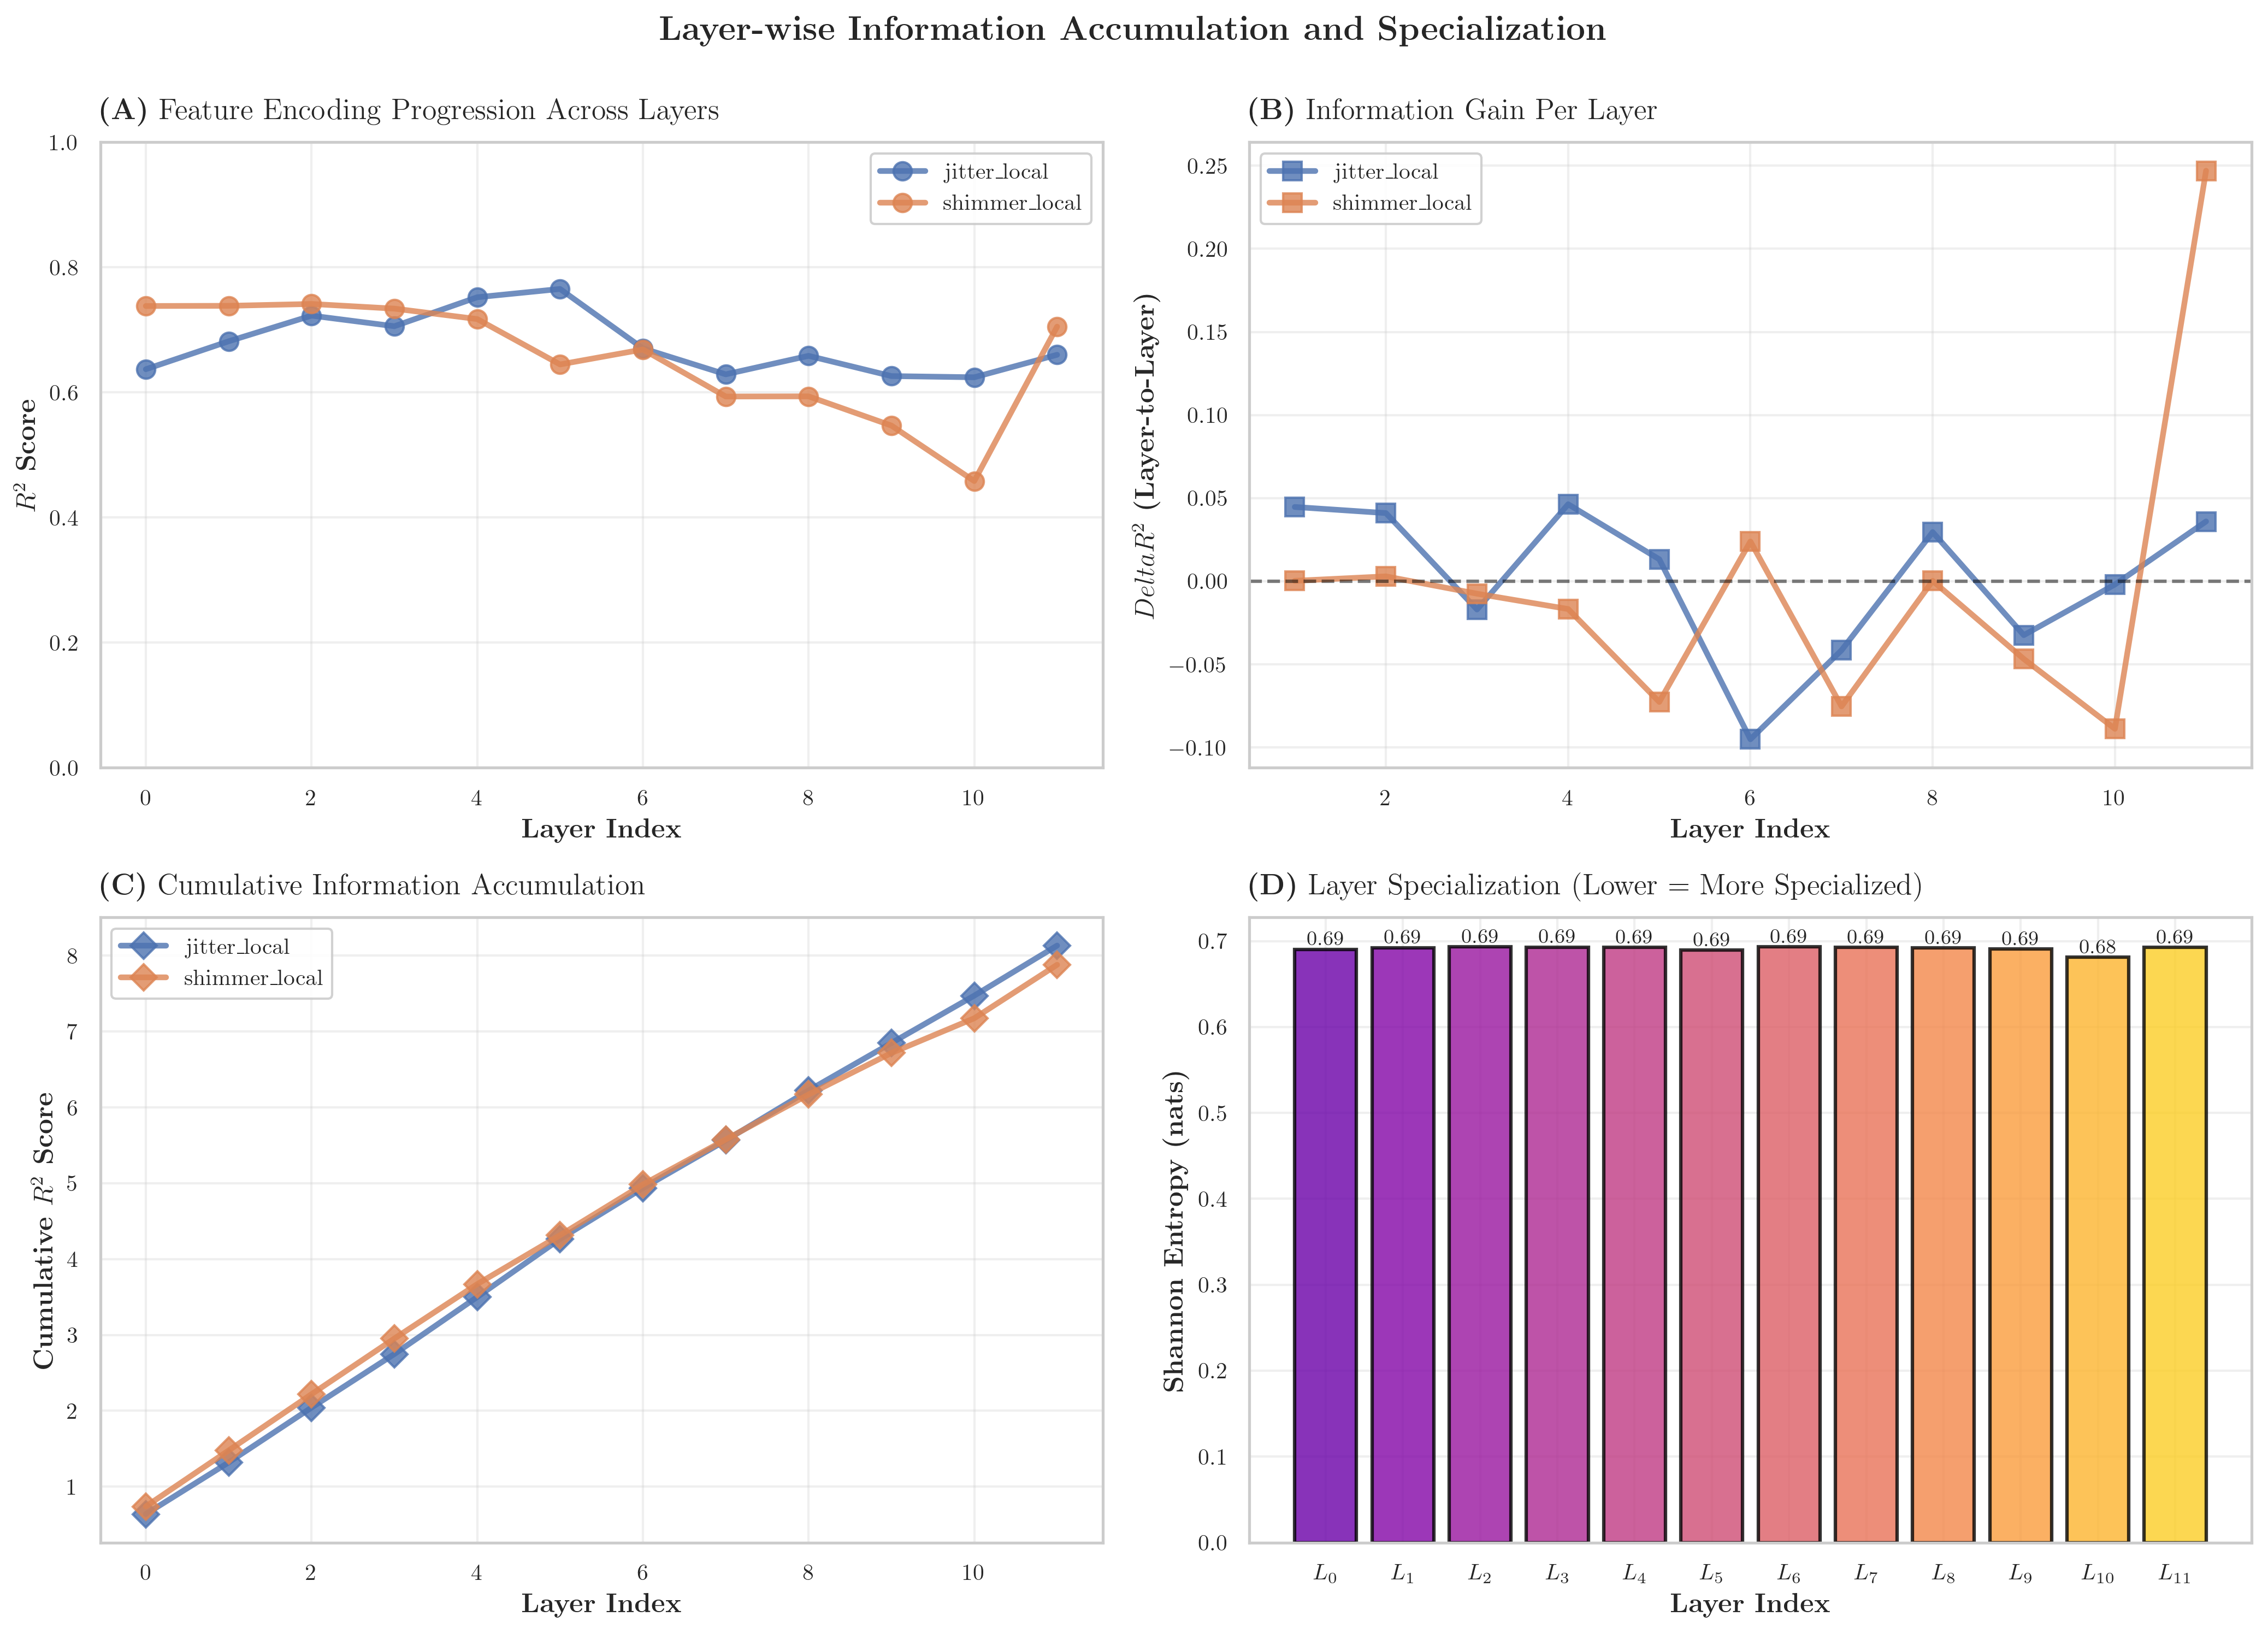

In [ ]:
# figure p8-02: layer-wise information accumulation
# shows how clinical feature encoding builds across layers

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# panel a: r2 progression curves per feature
ax = axes[0, 0]
for i, feat in enumerate(features):
    r2_scores = [probing_results[feat][str(l)]['r2_score'] for l in layers]
    ax.plot(layers, r2_scores, marker='o', linewidth=2.5, markersize=8,
           label=feat.replace('_', r'\_'), alpha=0.8)

ax.set_xlabel(r'\textbf{Layer Index}', fontsize=12)
ax.set_ylabel(r'\textbf{$R^2$ Score}', fontsize=12)
ax.set_title(r'\textbf{(A)} Feature Encoding Progression Across Layers',
            fontsize=13, pad=10, loc='left')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])

# panel b: layer-to-layer delta (information gain)
ax = axes[0, 1]
for i, feat in enumerate(features):
    r2_scores = [probing_results[feat][str(l)]['r2_score'] for l in layers]
    deltas = np.diff(r2_scores)
    ax.plot(layers[1:], deltas, marker='s', linewidth=2.5, markersize=8,
           label=feat.replace('_', r'\_'), alpha=0.8)

ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.set_xlabel(r'\textbf{Layer Index}', fontsize=12)
ax.set_ylabel(r'\textbf{$\\Delta R^2$ (Layer-to-Layer)}', fontsize=12)
ax.set_title(r'\textbf{(B)} Information Gain Per Layer',
            fontsize=13, pad=10, loc='left')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

# panel c: cumulative encoding strength
ax = axes[1, 0]
cumulative = np.cumsum(probing_matrix, axis=1)
for i, feat in enumerate(features):
    ax.plot(layers, cumulative[i], marker='D', linewidth=2.5, markersize=8,
           label=feat.replace('_', r'\_'), alpha=0.8)

ax.set_xlabel(r'\textbf{Layer Index}', fontsize=12)
ax.set_ylabel(r'\textbf{Cumulative $R^2$ Score}', fontsize=12)
ax.set_title(r'\textbf{(C)} Cumulative Information Accumulation',
            fontsize=13, pad=10, loc='left')
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

# panel d: layer specialization (entropy)
ax = axes[1, 1]
from scipy.stats import entropy

layer_entropy = []
for j, layer in enumerate(layers):
    # distribution of r2 scores across features for this layer
    layer_r2 = probing_matrix[:, j]
    # normalize to probability distribution
    layer_r2_norm = layer_r2 / (layer_r2.sum() + 1e-10)
    layer_entropy.append(entropy(layer_r2_norm + 1e-10))

colors_entropy = plt.cm.plasma(np.linspace(0.2, 0.9, len(layers)))
bars = ax.bar(range(len(layers)), layer_entropy, color=colors_entropy,
             edgecolor='black', linewidth=1.5, alpha=0.8)

ax.set_xticks(range(len(layers)))
ax.set_xticklabels([f'$L_{{{l}}}$' for l in layers])
ax.set_xlabel(r'\textbf{Layer Index}', fontsize=12)
ax.set_ylabel(r'\textbf{Shannon Entropy (nats)}', fontsize=12)
ax.set_title(r'\textbf{(D)} Layer Specialization (Lower = More Specialized)',
            fontsize=13, pad=10, loc='left')
ax.grid(True, alpha=0.3, axis='y')

# add values on bars
for bar, ent in zip(bars, layer_entropy):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{ent:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle(r'\textbf{Layer-wise Information Accumulation and Specialization}',
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

# save figure
plt.savefig(fig_path / 'fig_p8_02_layer_information_flow.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_02_layer_information_flow.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_02_layer_information_flow.svg', dpi=300, bbox_inches='tight')
print(f'saved: fig_p8_02_layer_information_flow.*')
plt.show()

saved: fig_p8_03_feature_contributions.*


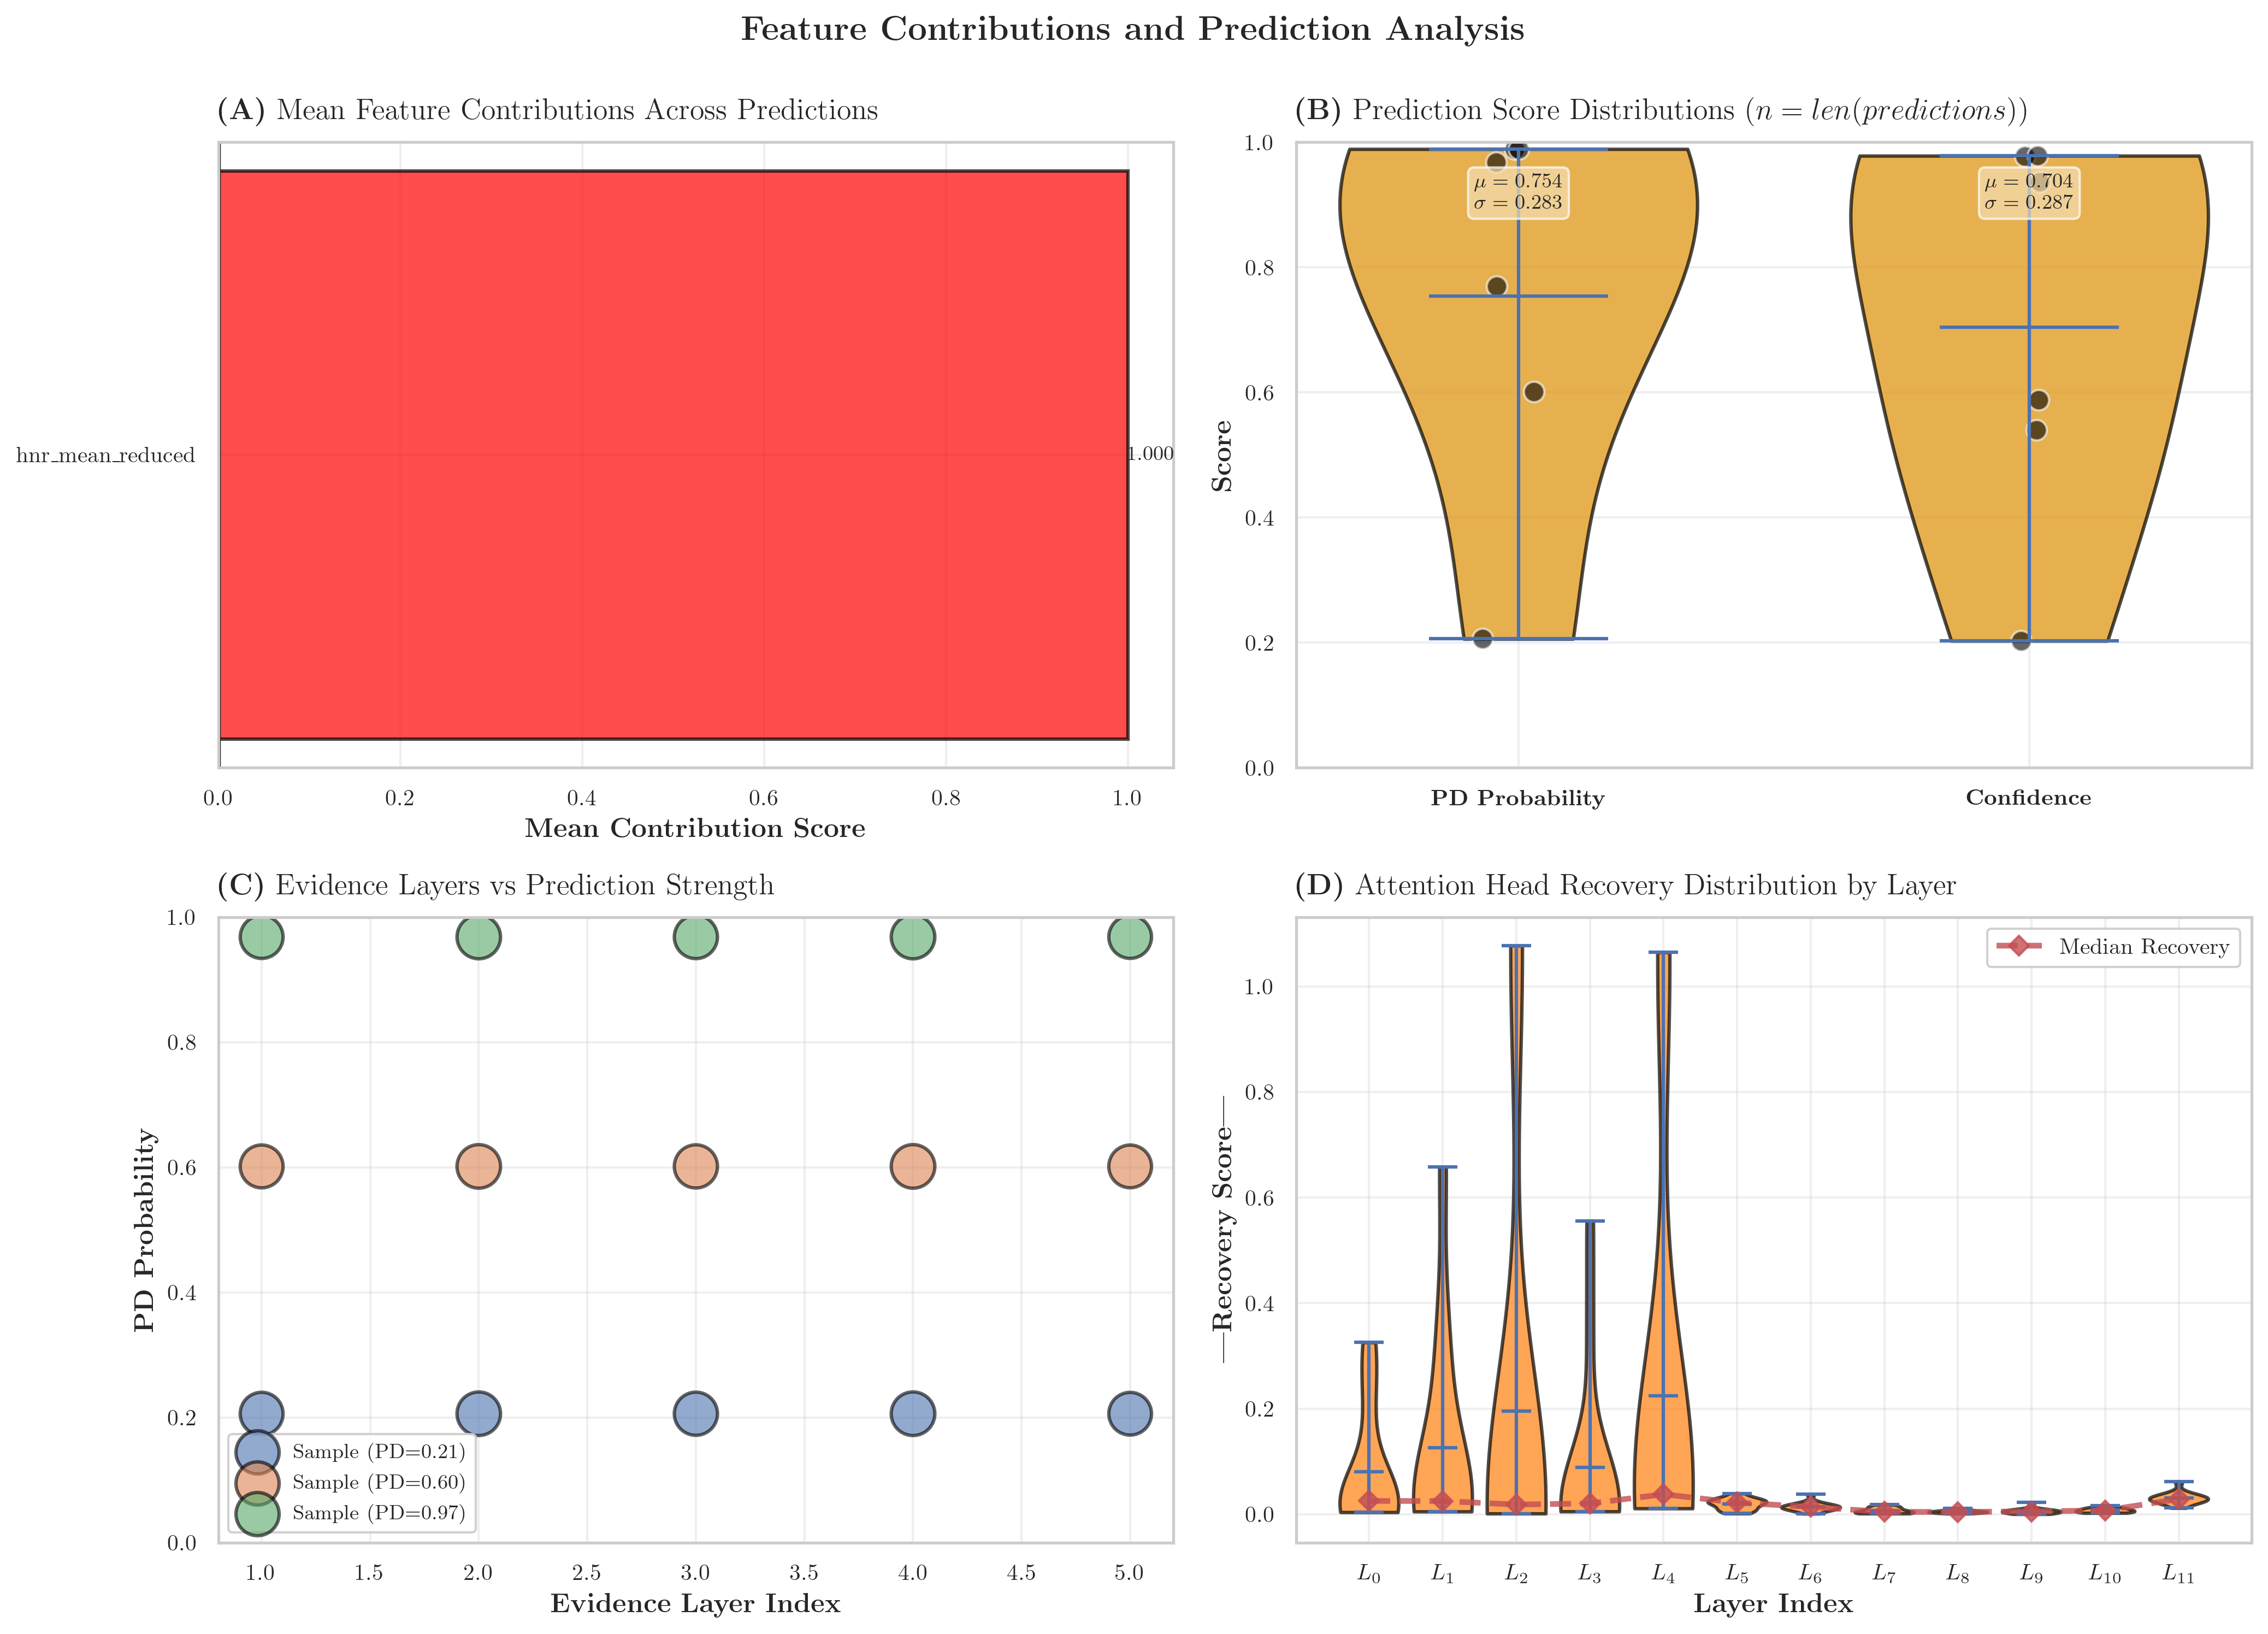

In [ ]:
# figure p8-03: feature contribution breakdown and prediction analysis
# detailed analysis of how features contribute to predictions

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# panel a: feature contribution waterfall chart
ax = axes[0, 0]

# aggregate feature contributions across predictions
all_contributions = {}
for pred in predictions:
    for feat, score in pred.feature_contributions.items():
        if feat not in all_contributions:
            all_contributions[feat] = []
        all_contributions[feat].append(score)

# compute mean contributions
mean_contributions = {k: np.mean(v) for k, v in all_contributions.items()}
sorted_features = sorted(mean_contributions.items(), key=lambda x: abs(x[1]), reverse=True)

if sorted_features:
    feats_sorted, scores_sorted = zip(*sorted_features)
    colors_contrib = ['red' if s > 0 else 'blue' for s in scores_sorted]

    bars = ax.barh(range(len(feats_sorted)), scores_sorted, color=colors_contrib,
                  edgecolor='black', linewidth=1.5, alpha=0.7)

    ax.set_yticks(range(len(feats_sorted)))
    ax.set_yticklabels([f.replace('_', r'\_') for f in feats_sorted])
    ax.invert_yaxis()
    ax.set_xlabel(r'\textbf{Mean Contribution Score}', fontsize=12)
    ax.set_title(r'\textbf{(A)} Mean Feature Contributions Across Predictions',
                fontsize=13, pad=10, loc='left')
    ax.grid(True, alpha=0.3, axis='x')
    ax.axvline(x=0, color='black', linewidth=2)

    # add values
    for i, (bar, score) in enumerate(zip(bars, scores_sorted)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f' {score:.3f}', ha='left' if width > 0 else 'right',
               va='center', fontweight='bold', fontsize=9)

# panel b: prediction probability distribution
ax = axes[0, 1]

probabilities = [p.pd_probability for p in predictions]
confidences = [p.confidence for p in predictions]

# violin plot
parts = ax.violinplot([probabilities, confidences], positions=[0, 1],
                      showmeans=True, showextrema=True, widths=0.7)

for pc in parts['bodies']:
    pc.set_facecolor(COLORS['PD'])
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

# overlay strip plot
for i, data in enumerate([probabilities, confidences]):
    x = np.random.normal(i, 0.04, size=len(data))
    ax.scatter(x, data, alpha=0.6, s=80, c='black', edgecolors='white', linewidths=1)

ax.set_xticks([0, 1])
ax.set_xticklabels([r'\textbf{PD Probability}', r'\textbf{Confidence}'])
ax.set_ylabel(r'\textbf{Score}', fontsize=12)
ax.set_title(r'\textbf{(B)} Prediction Score Distributions ($n={len(predictions)}$)',
            fontsize=13, pad=10, loc='left')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# add summary statistics
for i, (data, label) in enumerate(zip([probabilities, confidences], ['Prob', 'Conf'])):
    mean_val = np.mean(data)
    std_val = np.std(data)
    ax.text(i, 0.95, rf"""$\mu={mean_val:.3f}$
$\sigma={std_val:.3f}$""",
           ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round',
           facecolor='wheat', alpha=0.7))

# panel c: evidence layer vs prediction strength
ax = axes[1, 0]

# for each prediction, plot evidence layer scores vs pd probability
for pred in predictions[:3]:  # show first 3 for clarity
    evidence_idx = [int(l) for l in pred.evidence_layers if int(l) < len(layer_probing_avg)]
    if evidence_idx:
        evidence_r2 = [layer_probing_avg[i] for i in evidence_idx]
        ax.scatter(evidence_idx, [pred.pd_probability] * len(evidence_idx),
                  s=np.array(evidence_r2) * 500, alpha=0.6,
                  label=f'Sample (PD={pred.pd_probability:.2f})',
                  edgecolors='black', linewidths=1.5)

ax.set_xlabel(r'\textbf{Evidence Layer Index}', fontsize=12)
ax.set_ylabel(r'\textbf{PD Probability}', fontsize=12)
ax.set_title(r'\textbf{(C)} Evidence Layers vs Prediction Strength',
            fontsize=13, pad=10, loc='left')
ax.legend(loc='best', framealpha=0.9, fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# panel d: attention head recovery distribution by layer
ax = axes[1, 1]

# group heads by layer
layer_recoveries = [[] for _ in range(n_layers_patch)]
for (layer, head), score in patching_results.items():
    layer_recoveries[layer].append(abs(score))

# violin plot
positions = list(range(n_layers_patch))
parts = ax.violinplot([r for r in layer_recoveries if r], positions=[i for i, r in enumerate(layer_recoveries) if r],
                      showmeans=True, showextrema=True, widths=0.8)

for pc in parts['bodies']:
    pc.set_facecolor('#ff7f0e')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

ax.set_xlabel(r'\textbf{Layer Index}', fontsize=12)
ax.set_ylabel(r'\textbf{|Recovery Score|}', fontsize=12)
ax.set_title(r'\textbf{(D)} Attention Head Recovery Distribution by Layer',
            fontsize=13, pad=10, loc='left')
ax.set_xticks(range(n_layers_patch))
ax.set_xticklabels([f'$L_{{{l}}}$' for l in range(n_layers_patch)])
ax.grid(True, alpha=0.3, axis='y')

# add median line across layers
medians = [np.median(r) if r else 0 for r in layer_recoveries]
ax.plot(range(n_layers_patch), medians, 'r--', linewidth=2.5,
       label='Median Recovery', alpha=0.8, marker='D', markersize=6)
ax.legend(loc='best', framealpha=0.9)

plt.suptitle(r'\textbf{Feature Contributions and Prediction Analysis}',
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

# save figure
plt.savefig(fig_path / 'fig_p8_03_feature_contributions.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_03_feature_contributions.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_03_feature_contributions.svg', dpi=300, bbox_inches='tight')
print(f'saved: fig_p8_03_feature_contributions.*')
plt.show()

saved: fig_p8_04_interpretability_pipeline.*


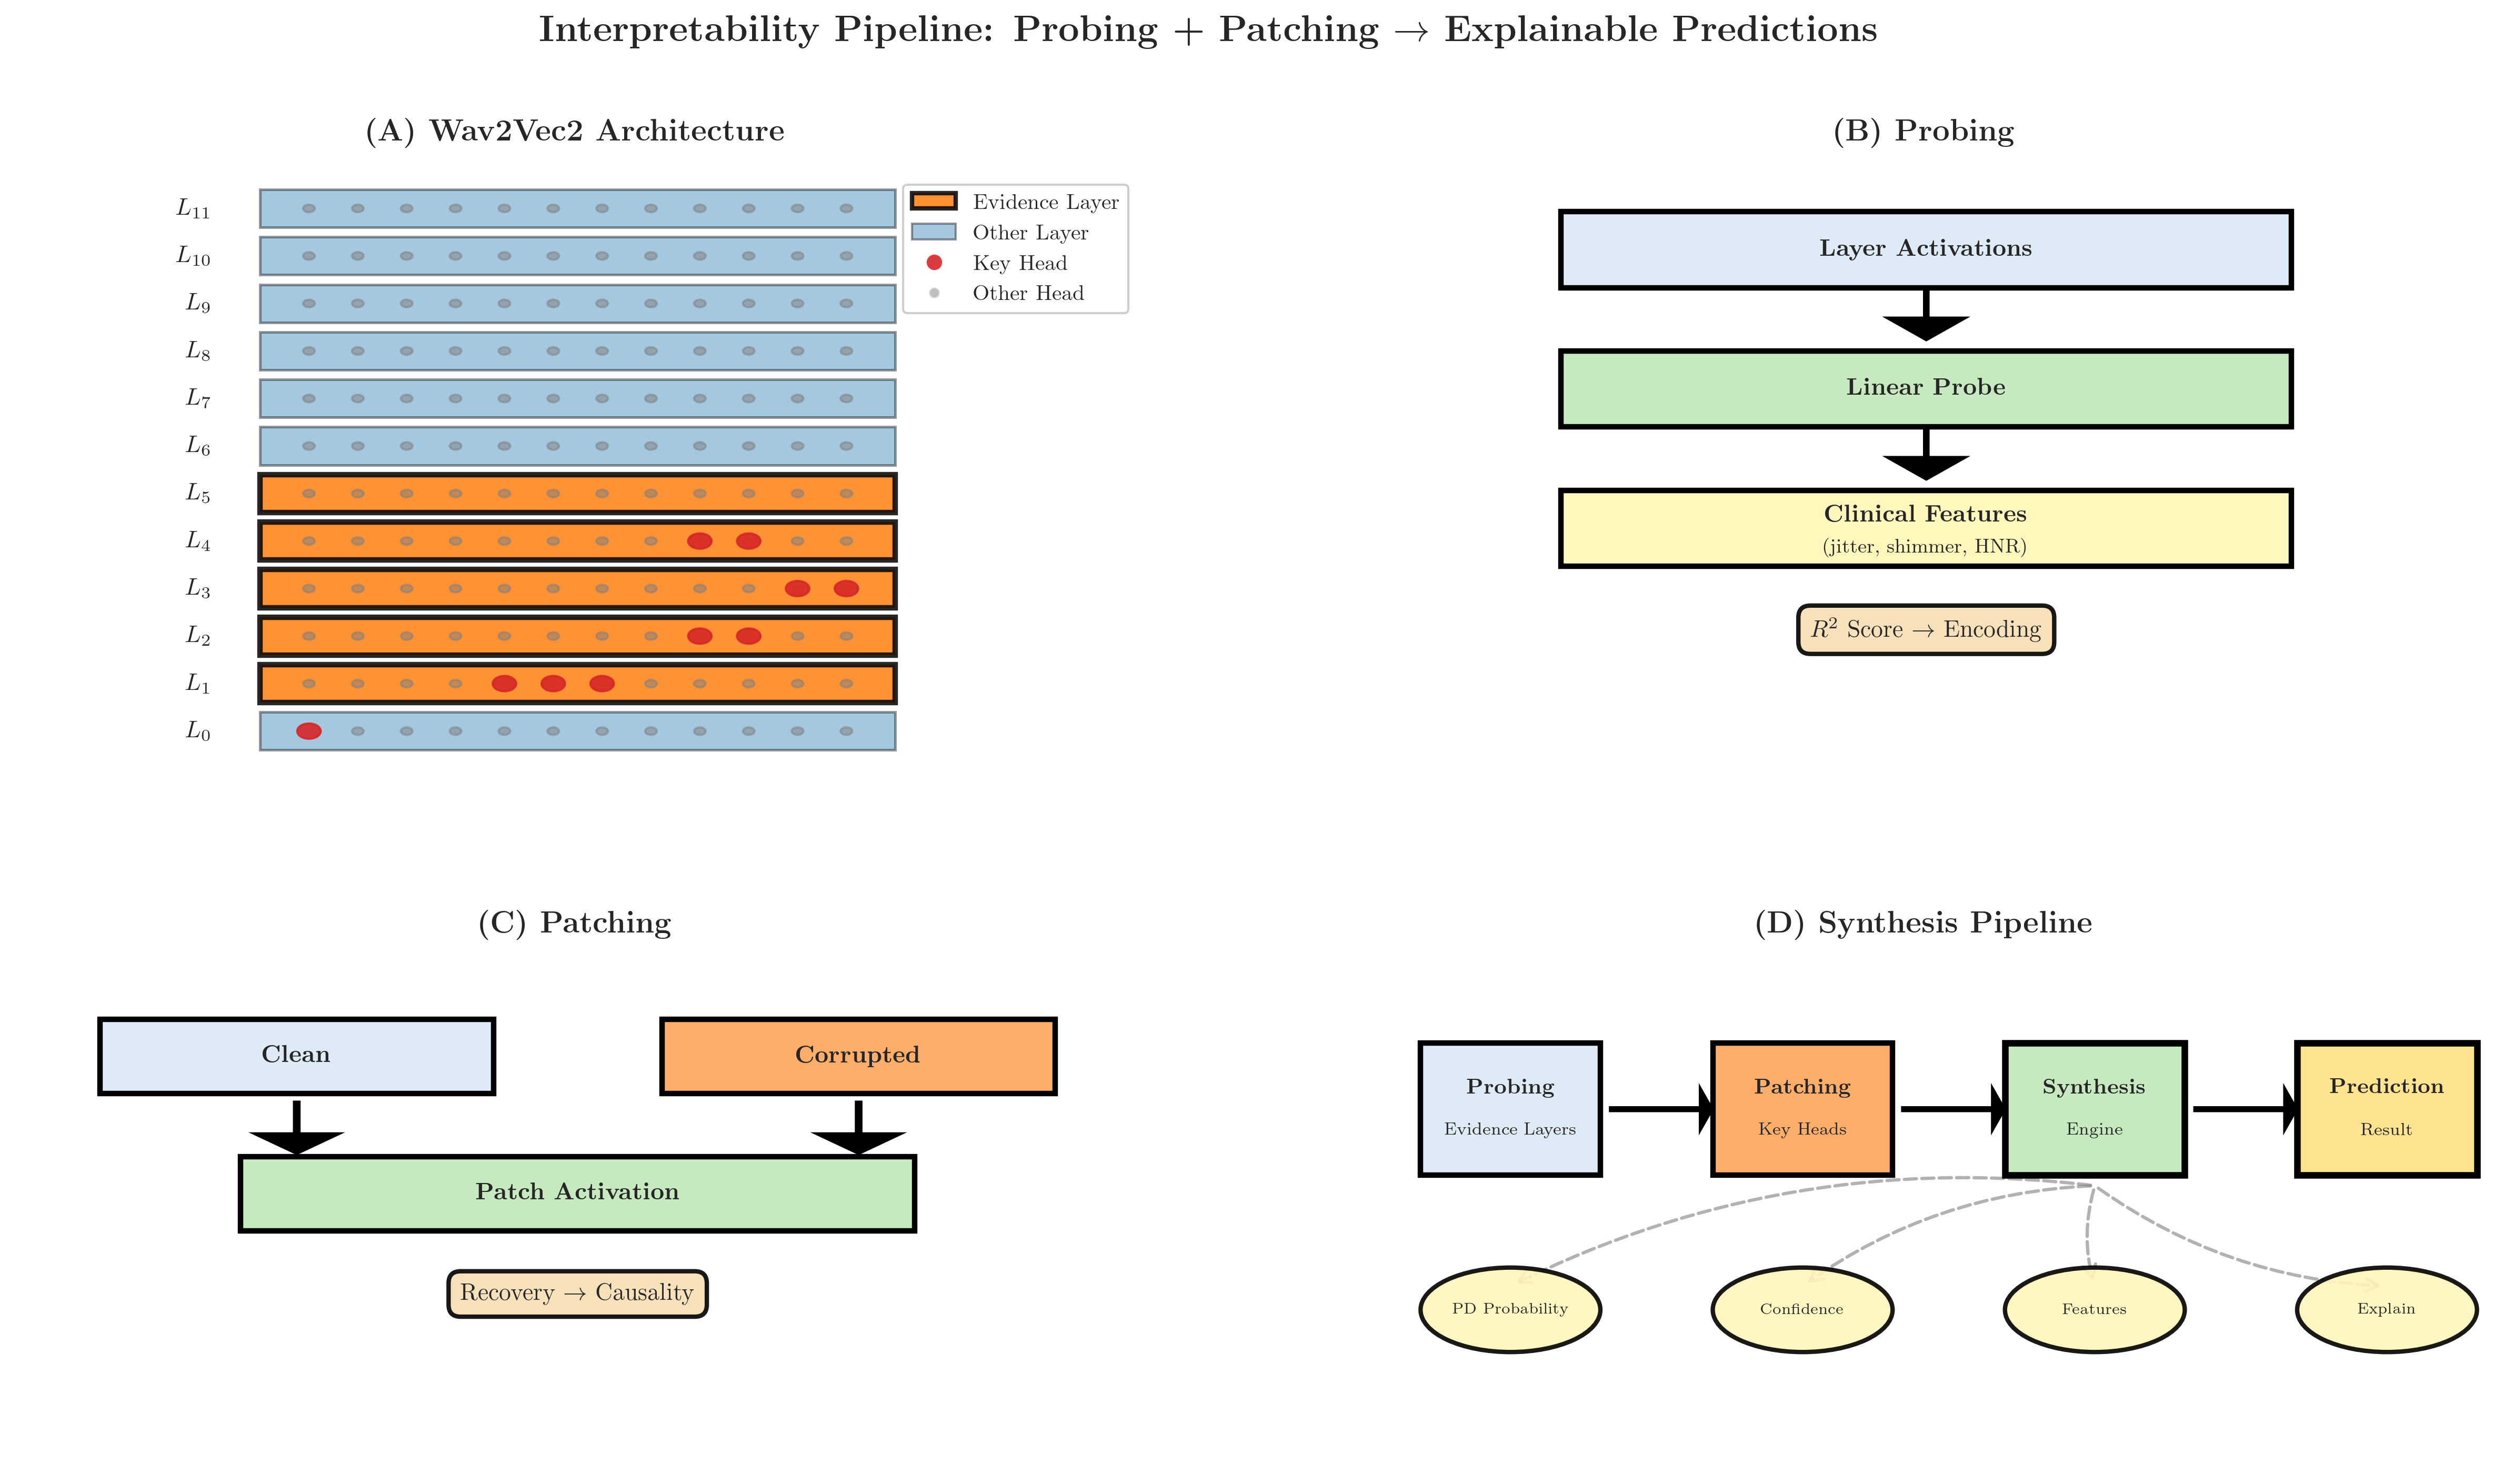

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch, FancyArrowPatch

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1, 0.8], hspace=0.3, wspace=0.2,
                     left=0.08, right=0.95, top=0.92, bottom=0.06)
ax1 = fig.add_subplot(gs[0, 0])
ax1.axis('off')

# draw simplified transformer stack (vertical)
n_layers_viz = 12
layer_height = 0.06
layer_width = 0.65
layer_spacing = 0.015

evidence_layers_viz = [int(l) for l in interface._evidence_layers]

# start from bottom
y_base = 0.05
for layer_idx in range(n_layers_viz):
    y_pos = y_base + layer_idx * (layer_height + layer_spacing)

    # color based on whether it's an evidence layer
    if layer_idx in evidence_layers_viz:
        color = '#ff7f0e'  # orange
        linewidth = 2.5
        alpha = 0.85
    else:
        color = '#1f77b4'  # blue
        linewidth = 1.2
        alpha = 0.4

    rect = plt.Rectangle((0.2, y_pos), layer_width, layer_height,
                         facecolor=color, edgecolor='black',
                         linewidth=linewidth, alpha=alpha, zorder=10)
    ax1.add_patch(rect)

    # layer label on left
    ax1.text(0.15, y_pos + layer_height/2, f'$L_{{{layer_idx}}}$',
            ha='right', va='center', fontsize=11, fontweight='bold', zorder=12)

    # attention heads as small circles inside
    n_heads_viz = 12
    head_spacing = layer_width / (n_heads_viz + 1)
    for head_idx in range(n_heads_viz):
        head_x = 0.2 + (head_idx + 1) * head_spacing
        head_y = y_pos + layer_height/2

        if (layer_idx, head_idx) in top_heads[:10]:
            head_color = '#d62728'  # red
            head_radius = 0.012
            head_alpha = 0.9
        else:
            head_color = 'gray'
            head_radius = 0.006
            head_alpha = 0.5

        circle = plt.Circle((head_x, head_y), head_radius,
                           color=head_color, alpha=head_alpha, zorder=11)
        ax1.add_patch(circle)

# add legend
legend_elements = [
    Patch(facecolor='#ff7f0e', edgecolor='black', linewidth=2, alpha=0.85,
          label='Evidence Layer'),
    Patch(facecolor='#1f77b4', edgecolor='black', linewidth=1, alpha=0.4,
          label='Other Layer'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#d62728',
              markersize=8, alpha=0.9, label='Key Head'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
              markersize=5, alpha=0.5, label='Other Head')
]
ax1.legend(handles=legend_elements, bbox_to_anchor=(0.78, 0.96), loc='upper left', framealpha=0.95,
          fontsize=10, ncol=1)

ax1.set_xlim([-0.05, 1.1])
ax1.set_ylim([0, 1])
ax1.set_title(r'\textbf{(A) Wav2Vec2 Architecture}',
             fontsize=14, pad=0, loc='center', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
ax2.axis('off')

# vertical flowchart
y_curr = 0.90
box_h = 0.12
box_w = 0.65
x_center = 0.5

# step 1: layer activations
rect1 = plt.Rectangle((x_center - box_w/2, y_curr - box_h), box_w, box_h,
                      facecolor='#deebf7', edgecolor='black', linewidth=2.5, zorder=10)
ax2.add_patch(rect1)
ax2.text(x_center, y_curr - box_h/2, r'\textbf{Layer Activations}',
        ha='center', va='center', fontsize=11, fontweight='bold', zorder=11)

# arrow
y_curr -= (box_h + 0.08)
ax2.arrow(x_center, y_curr + 0.08, 0, -0.05,
         head_width=0.06, head_length=0.03, fc='black', ec='black', linewidth=2.5, zorder=5)

# step 2: linear probe
y_curr -= 0.02
rect2 = plt.Rectangle((x_center - box_w/2, y_curr - box_h), box_w, box_h,
                      facecolor='#c7e9c0', edgecolor='black', linewidth=2.5, zorder=10)
ax2.add_patch(rect2)
ax2.text(x_center, y_curr - box_h/2, r'\textbf{Linear Probe}',
        ha='center', va='center', fontsize=11, fontweight='bold', zorder=11)

# arrow
y_curr -= (box_h + 0.08)
ax2.arrow(x_center, y_curr + 0.08, 0, -0.05,
         head_width=0.06, head_length=0.03, fc='black', ec='black', linewidth=2.5, zorder=5)

# step 3: clinical features
y_curr -= 0.02
rect3 = plt.Rectangle((x_center - box_w/2, y_curr - box_h), box_w, box_h,
                      facecolor='#fff7bc', edgecolor='black', linewidth=2.5, zorder=10)
ax2.add_patch(rect3)
ax2.text(x_center, y_curr - box_h/2 + 0.02, r'\textbf{Clinical Features}',
        ha='center', va='center', fontsize=11, fontweight='bold', zorder=11)
ax2.text(x_center, y_curr - box_h/2 - 0.03, r'(jitter, shimmer, HNR)',
        ha='center', va='center', fontsize=9, style='italic', zorder=11)

# result box
y_curr -= (box_h + 0.10)
ax2.text(x_center, y_curr, r'$R^2$ Score $\rightarrow$ Encoding',
        ha='center', va='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat',
                 edgecolor='black', linewidth=2, alpha=0.9), zorder=11)

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_title(r'\textbf{(B) Probing}',
             fontsize=14, pad=0, loc='center', fontweight='bold')

ax3 = fig.add_subplot(gs[1, 0])
ax3.axis('off')

y_start = 0.85
box_h = 0.14
small_box_w = 0.35
gap = 0.15

# clean run (left)
x_left = 0.25
rect_c1 = plt.Rectangle((x_left - small_box_w/2, y_start - box_h), small_box_w, box_h,
                        facecolor='#deebf7', edgecolor='black', linewidth=2.5, zorder=10)
ax3.add_patch(rect_c1)
ax3.text(x_left, y_start - box_h/2, r'\textbf{Clean}',
        ha='center', va='center', fontsize=11, fontweight='bold', zorder=11)

# corrupted run (right)
x_right = 0.75
rect_c2 = plt.Rectangle((x_right - small_box_w/2, y_start - box_h), small_box_w, box_h,
                        facecolor='#fdae6b', edgecolor='black', linewidth=2.5, zorder=10)
ax3.add_patch(rect_c2)
ax3.text(x_right, y_start - box_h/2, r'\textbf{Corrupted}',
        ha='center', va='center', fontsize=11, fontweight='bold', zorder=11)

# arrows down
y_arrow = y_start - box_h - 0.10
ax3.arrow(x_left, y_start - box_h - 0.02, 0, -0.06,
         head_width=0.06, head_length=0.03, fc='black', ec='black',
         linewidth=3, zorder=5)
ax3.arrow(x_right, y_start - box_h - 0.02, 0, -0.06,
         head_width=0.06, head_length=0.03, fc='black', ec='black',
         linewidth=3, zorder=5)

# patch operation (center, merged)
y_patch = y_arrow - 0.02
x_center_patch = 0.5
patch_box_w = 0.60
rect_c3 = plt.Rectangle((x_center_patch - patch_box_w/2, y_patch - box_h),
                        patch_box_w, box_h,
                        facecolor='#c7e9c0', edgecolor='black', linewidth=2.5, zorder=10)
ax3.add_patch(rect_c3)
ax3.text(x_center_patch, y_patch - box_h/2, r'\textbf{Patch Activation}',
        ha='center', va='center', fontsize=11, fontweight='bold', zorder=11)

# result
y_result = y_patch - box_h - 0.12
ax3.text(x_center_patch, y_result, r'Recovery $\rightarrow$ Causality',
        ha='center', va='center', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat',
                 edgecolor='black', linewidth=2, alpha=0.9), zorder=11)

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_title(r'\textbf{(C) Patching}',
             fontsize=14, pad=0, loc='center', fontweight='bold')

ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')

# horizontal pipeline
y_pipeline = 0.68
box_h_pipe = 0.25
box_w_pipe = 0.16

# positions (adjusted for centering and new width)
total_pipe_width = 4 * box_w_pipe + 3 * 0.1
x_start_pipe = (1 - total_pipe_width) / 2 + 0.1
positions = [x_start_pipe + i * (box_w_pipe + 0.1) for i in range(4)]

labels = [
    (r'\textbf{Probing}', ['Evidence Layers']),
    (r'\textbf{Patching}', ['Key Heads']),
    (r'\textbf{Synthesis}', ['Engine']),
    (r'\textbf{Prediction}', ['Result'])
]
colors = ['#deebf7', '#fdae6b', '#c7e9c0', '#fee391']
linewidths = [2.5, 2.5, 3, 3]

for i, (x_pos, (main_label, sub_labels), color, lw) in enumerate(zip(positions, labels, colors, linewidths)):
    # box
    rect = plt.Rectangle((x_pos - box_w_pipe/2, y_pipeline - box_h_pipe/2),
                         box_w_pipe, box_h_pipe,
                         facecolor=color, edgecolor='black', linewidth=lw, zorder=10)
    ax4.add_patch(rect)

    # main label
    y_main = y_pipeline + 0.04
    ax4.text(x_pos, y_main, main_label,
            ha='center', va='center', fontsize=10, fontweight='bold', zorder=11)

    # sub labels
    if sub_labels:
        y_sub_start = y_pipeline - 0.04
        for j, sub in enumerate(sub_labels):
            ax4.text(x_pos, y_sub_start - j*0.06, sub,
                    ha='center', va='center', fontsize=8, zorder=11)

    # arrow to next box
    if i < len(positions) - 1:
        arrow_x_start = x_pos + box_w_pipe/2 + 0.01
        arrow_x_end = positions[i+1] - box_w_pipe/2 - 0.01
        ax4.arrow(arrow_x_start, y_pipeline, arrow_x_end - arrow_x_start, 0,
                 head_width=0.06, head_length=0.008, fc='black', ec='black',
                 linewidth=2.5, zorder=5)

# output circles below
y_outputs = 0.3
output_labels = ['PD Probability', 'Confidence', 'Features', 'Explain']
output_positions = [p for p in positions]

for x_out, label in zip(output_positions, output_labels):
    # circle
    circle = plt.Circle((x_out, y_outputs), 0.08, facecolor='#fff7bc',
                       edgecolor='black', linewidth=2, alpha=0.9, zorder=10)
    ax4.add_patch(circle)
    ax4.text(x_out, y_outputs, label,
            ha='center', va='center', fontsize=7, fontweight='bold', zorder=11)

    # curved arrow from synthesis box to output
    synthesis_x = positions[2]
    synthesis_y_bottom = y_pipeline - box_h_pipe/2

    arrow_end_y_fancy = y_outputs + 0.07 - 0.025
    arrow = FancyArrowPatch((synthesis_x, synthesis_y_bottom - 0.02),
                           (x_out, arrow_end_y_fancy),
                           arrowstyle='->', mutation_scale=15, linewidth=1.5,
                           color='gray', alpha=0.6, linestyle='--',
                           connectionstyle='arc3,rad=0.15', zorder=5)
    ax4.add_patch(arrow)

ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])
ax4.set_title(r'\textbf{(D) Synthesis Pipeline}',
             fontsize=14, pad=0, loc='center', fontweight='bold') # Set pad to 0

# main title
fig.suptitle(r'\textbf{Interpretability Pipeline: Probing + Patching $\rightarrow$ Explainable Predictions}',
            fontsize=17, fontweight='bold', y=0.98)

# save figure
fig_path = Path(CONFIG['output_path']) / 'phase5_synthesis'
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'fig_p8_04_interpretability_pipeline.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_04_interpretability_pipeline.png', dpi=300, bbox_inches='tight')
plt.savefig(fig_path / 'fig_p8_04_interpretability_pipeline.svg', dpi=300, bbox_inches='tight')
print(f'saved: fig_p8_04_interpretability_pipeline.*')
plt.show()

## 9. Save Results

In [ ]:
# save all predictions
output_dir = Path(CONFIG['project_path']) / 'results' / 'phase5_synthesis'
output_dir.mkdir(parents=True, exist_ok=True)

# save individual predictions
for sample, prediction in zip(test_samples, predictions):
    prediction.metadata['subject_id'] = sample['subject_id']
    prediction.metadata['true_label'] = sample['label']

    interface.save_prediction(
        prediction,
        output_dir / f"{sample['subject_id']}_prediction.json"
    )

# save summary
summary = {
    'n_samples': len(predictions),
    'mean_pd_probability': float(np.mean(probs)),
    'mean_confidence': float(np.mean(confs)),
    'n_predicted_pd': sum(1 for p in probs if p >= 0.5),
    'n_predicted_hc': sum(1 for p in probs if p < 0.5)
}

with open(output_dir / 'prediction_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {output_dir}")

Results saved to /content/drive/MyDrive/pd-interpretability/results/phase5_synthesis
